With [ImageView](https://github.com/timholy/ImageView.jl) you can easily note the (x,y) coordinates of the measurements in the calibration pictures.

We refer to the excellent [CAN-EYE user guide](http://www6.paca.inra.fr/can-eye/Documentation-Publications/Documentation) for the calibration setup.

In [1]:
using Images, ImageView

In [2]:
im1 = imread("20dist.JPG")
im2 = imread("25dist.JPG")
show(im2)

RGB Image with:
  data: 6000x4000 Array{RGB{UfixedBase{Uint8,8}},2}
  properties:
    IMcs: sRGB
    spatialorder:  x y
    pixelspacing:  1 1

In [3]:
view(im2)
view(im2)

(ImageCanvas,ImageSlice2d: zoom = BoundingBox(0.0,6000.0,0.0,4000.0))

In [ ]:
using DataFrames

Note down the x pixels coordinate at half height for each measurement. See `lenscalibration.csv` for an exmple.

In [5]:
lens = readtable("lenscalibration.csv")


before the new definition.


,ruler_cm,x_pic_pixels,H_Lens_distance,position
1,19,1405,20,left
2,18,1460,20,left
3,17,1518,20,left
4,16,1572,20,left
5,15,1632,20,left
6,14,1688,20,left
7,13,1745,20,left
8,12,1799,20,left
9,11,1850,20,left
10,10,1897,20,left


In [6]:
H1, H2 = extrema(lens[:H_Lens_distance])

(20,25)

In [7]:
center1 = lens[(lens[:position].=="perpendicular") & (lens[:ruler_cm] .== 0
                ) & (lens[:H_Lens_distance] .== H1), :x_pic_pixels][1]

2963

In [8]:
center2 = lens[(lens[:position].=="perpendicular") & (lens[:ruler_cm] .== 0
                ) & (lens[:H_Lens_distance] .== H2), :x_pic_pixels][1]

2976

We use 2 pictures at different distances `H1, H2` from the perpendicular ruler to estimate the distance to the perpendicular ruler more precisely than with a physical ruler during setup. Alternatively you can use a single image from a (much) larger calibration setup, eg a ruler on the ceiling and across the side walls.

We first estimate more correctly the distance difference $\Delta$ between im1 and im2 by noticing that the shift on the lateral rulers between the two pictures is equal to $\Delta$.

In [9]:
# auxilary function to interpolate a pixel from image 1 to the ruler of image 2
function interpol(x, df2, center2)

    # suffix 2 is for second image with H2
    s2 = sort(df2, cols=:x_pic_pixels)
    x2 = s2[:x_pic_pixels] - center2
    cm2 = s2[:ruler_cm]        

    if (x < minimum(x2)) | (x > maximum(x2))
        return(nan(Float64))
    end

    ind = searchsortedfirst(x2, x)    
    out = cm2[ind] - (x2[ind] - x)/(x2[ind]-x2[ind-1])*(cm2[ind]-cm2[ind-1])
end

interpol (generic function with 1 method)

In [10]:
# fitting function to optimize Δ
function fitΔ(Δ, df1, df2, center1, center2; errfun::Function=x->x^2)
    diffs = Float64[]
    for row = 1:size(df1, 1)
        x = df1[row, :x_pic_pixels] - center1
        cm2 = interpol(x, df2, center2)
        !isnan(cm2) && push!(diffs, cm2 - df1[row, :ruler_cm] - Δ)
    end
    s = sum(map(errfun,diffs))        
    return s
end

fitΔ (generic function with 1 method)

In [11]:
# starting point for optimization
Δinit = H2 - H1

5

In [12]:
using Optim

In [13]:
left1 = lens[(lens[:position].=="left") & (lens[:H_Lens_distance] .== H1),:]
left2 = lens[(lens[:position].=="left") & (lens[:H_Lens_distance] .== H2),:]
resleft = optimize(Δ -> fitΔ(Δ,left1,left2,center1,center2), Δinit/2, Δinit*3/2)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.500000, 7.500000]
 * Minimum: 5.451314
 * Value of Function at Minimum: 1.286501
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6


In [14]:
right1 = lens[(lens[:position].=="right") & (lens[:H_Lens_distance] .== H1),:]
right2 = lens[(lens[:position].=="right") & (lens[:H_Lens_distance] .== H2),:]
resright = optimize(Δ -> fitΔ(Δ,right1,right2,center1,center2), Δinit/2, Δinit*3/2)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.500000, 7.500000]
 * Minimum: 5.790339
 * Value of Function at Minimum: 0.165669
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6


In [15]:
Δ = (resleft.minimum + resright.minimum)/2

5.620826421801778

With a more precise estimation of Δ, we can estimate H1 more precisely.

We optimize H1 for the value that provides the best fit between the two projection functions of the two images. We fit a 2nd degree polynomial without intercept to the projection functions $\theta(\rho) = a\theta + b\theta^2$.

For higher order polynomial, simply adjust the `abfit` function accordingly.

In [16]:
# perpendicular ruler half width
w = maximum(lens[lens[:position] .== "perpendicular", :ruler_cm ])

15

In [17]:
function projfunpoints(df, center, H)
    θset = Float64[]
    ρset = Int[]
    for row = 1:size(df,1)
        cm = df[row, :ruler_cm]
        ρ = abs(df[row, :x_pic_pixels] - center)
        if df[row, :position] == "perpendicular"
            θ = atan(abs(cm) / H)
        else
            θ = atan(w / (H - cm))
        end
        push!(θset, θ)
        push!(ρset, ρ)
        #@show cm, ρ, df[row, :position], θ
    end
    θset, ρset
end

projfunpoints (generic function with 1 method)

In [18]:
lens1 = lens[lens[:H_Lens_distance] .== H1, :]
θ1, ρ1 = projfunpoints(lens1,center1, H1)

([1.50423,1.43824,1.3734,1.31019,1.24905,1.19029,1.13417,1.08084,1.03038,0.982794  …  0.291457,0.336675,0.380506,0.422854,0.463648,0.502843,0.54042,0.576375,0.610726,0.643501],[1558,1503,1445,1391,1331,1275,1218,1164,1113,1066  …  318,367,416,463,491,551,594,626,660,705])

In [19]:
using Winston

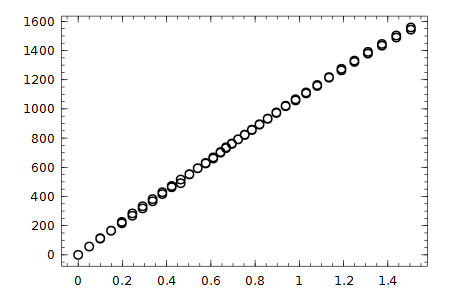

In [20]:
plot(θ1, ρ1, "o")

In [21]:
function abfit(θ, ρ)
    # fit ρ(θ) = aθ + bθ²
    A = [θᵢ^p for θᵢ in θ, p = 1:2]
    a,b = A \ ρ
end

abfit (generic function with 1 method)

(a,b) = abfit(θ1,ρ1) => [1142.1319418290147,-67.51000575799131]


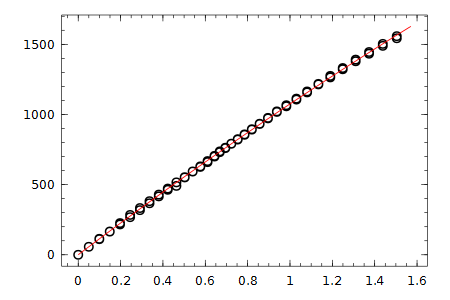

In [22]:
@show a,b = abfit(θ1, ρ1)
plot(θ1, ρ1, "o")
oplot(θ -> a*θ + b*θ.^2, 0, pi/2, "r")

(a2,b2) = abfit(θ2,ρ2) => [1147.905648591946,-73.17780611843375]


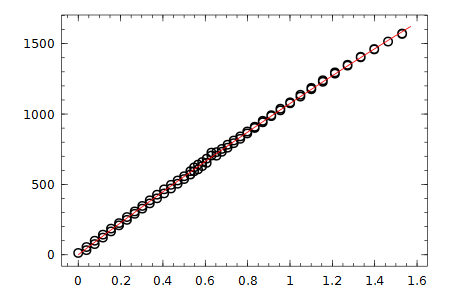

In [23]:
lens2 = lens[lens[:H_Lens_distance] .== H2, :]
θ2, ρ2 = projfunpoints(lens2,center1, H1+Δ)
@show a2, b2 = abfit(θ2, ρ2)
plot(θ2, ρ2, "o")
oplot(θ -> a2*θ + b2*θ.^2, 0, pi/2, "r")

In [24]:
abfit(projfunpoints(lens1,center1, H1)...)

2-element Array{Float64,1}:
 1142.13
  -67.51

In [25]:
function projfundiff(H, Δ, lens1, lens2, center1, center2)
    a1, b1 = abfit(projfunpoints(lens1, center1, H)...)
    a2, b2 = abfit(projfunpoints(lens2, center2, H+Δ)...)
    (a1 - a2).^2 + (b1-b2).^2
end

projfundiff (generic function with 1 method)

In [26]:
projfundiff(22, Δ,lens1, lens2, center1, center2)

59.45542382815183

In [27]:
Hres = optimize(H->projfundiff(H, Δ, lens1, lens2, center1, center2), H1/2,H1*2)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [10.000000, 40.000000]
 * Minimum: 21.114513
 * Value of Function at Minimum: 1.294852
 * Iterations: 10
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 11


In [28]:
H = Hres.minimum

21.11451342244008

In [29]:
@show a1, b1 = abfit(projfunpoints(lens1, center1, H)...)
@show a2, b2 = abfit(projfunpoints(lens2, center2, H+Δ)...)
@show a = (a1 + a2)/2
@show b = (b1 + b2)/2

(a1,b1) = abfit(projfunpoints(lens1,center1,H)...) => [1192.6856351102467,-66.4821622226864]
(a2,b2) = abfit(projfunpoints(lens2,center2,H + Δ)...) => [1191.985605067407,-67.37927417625603]
a = (a1 + a2) / 2 => 1192.335620088827
b = (b1 + b2) / 2 => -66.93071819947122


-66.93071819947122

These lens projection function parameters include the maximum radius of the image. Simply divide by this radius to get a projection function in the interval [0, 1] that can be used generically with different camera's (that have different maximum radius).